# Introduction

This will be an explanation of a dataset of properties of cars. The goal of the exploration is to use the information to predict the fuel efficiency (in miles per gallon). The dataset is contained in the file `data/auto-mpg.data` and a description of the data is in the file `data/auto-mpg.names`.

Loading required libraries:

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Some helpful functions have been written into separate python files

In [2]:
import processing as p
import regression as r

# Load the data

The data were loaded into a `pandas.DataFrame` object for ease of processing the mix of continuous and categorical data.

In [10]:
column_names = [
    'mpg', 'cylinders', 'displacement',
    'horsepower', 'weight', 'acceleration',
    'model year', 'origin', 'car name'
]
df = pd.read_csv('data/auto-mpg.data', header=None,
                 names=column_names, na_values='?',
                 sep='\s+')

In [17]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [11]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The dataset description calls out six missing values from the horsepower column. Since these records are relatively small compared to the rest of the dataset, for now I will delete the rows.

In [16]:
df_clean = df.dropna(axis=0)

In [18]:
df_clean.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Sure enough, 6 rows of data had NA values and have now been dropped.

# Split the data for cross-validation

Physically we would not expect that any individual car's properties should depend on any other car's properties. Therefore, if we want to divide the dataset to allow for **training**, **testing**, and **valdiation** data, we can simply randomly sample from the rows. I will use 50% of the data for training, 25% for validation, and 25% for testing and reporting.

In [36]:
mask_vals = np.random.rand(len(df_clean))
train_mask = mask_vals <= 0.5
val_mask = (mask_vals > 0.5) & (mask_vals < 0.75)
test_mask = mask_vals >= 0.75

In [37]:
train = df_clean[train_mask]
val = df_clean[val_mask]
test = df_clean[test_mask]

In [38]:
print(f'train length:\t{len(train)}\n'
      f'test length:\t{len(test)}\n'
      f'val length:\t{len(val)}')

train length:	204
test length:	94
val length:	94


Just in case, save these three datasets to files for later work

In [40]:
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)
val.to_csv('data/val.csv', index=False)

# Dataset description

From the description of the dataset above (`df_clean.describe()`) we see some information fairly quickly. First, the `pandas` library is treating discrete values as continuous (luckily it was smart enough to ignore the 'car name' column).

In [19]:
continuous_columns = ['mpg', 'displacement', 'horsepower',
                      'weight', 'acceleration']

In [41]:
train_continuous = train[continuous_columns]
val_continuous = val[continuous_columns]

# Initial regression

First examine the performance of a regression using only the continuous values without rescaling the data columns.

In [46]:
r.regress(x=train[continuous_columns[1:]].values, y=train['mpg'].values)

array([-1.10238027e-02, -4.96187570e-02, -4.52856397e-03, -6.22195205e-02,
        4.51209155e+01])

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'mpg (predicted)')

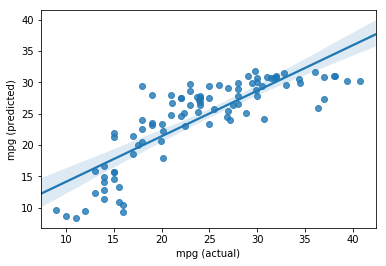

In [56]:
coefficients = r.regress(x=train[continuous_columns[1:]].values, y=train['mpg'].values)
sns.regplot(x=val['mpg'], 
                y=p.add_intercept_column(val[continuous_columns[1:]].values) \
                @ coefficients)
plt.xlabel('mpg (actual)')
plt.ylabel('mpg (predicted)')

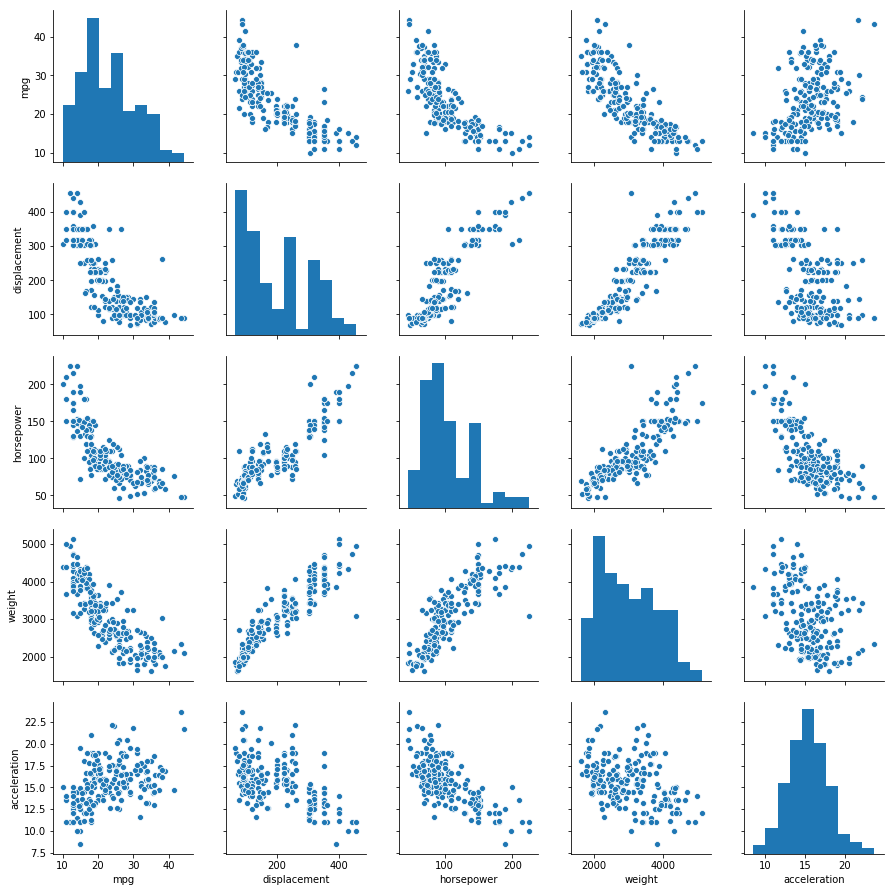

In [57]:
sns.pairplot(train_continuous)

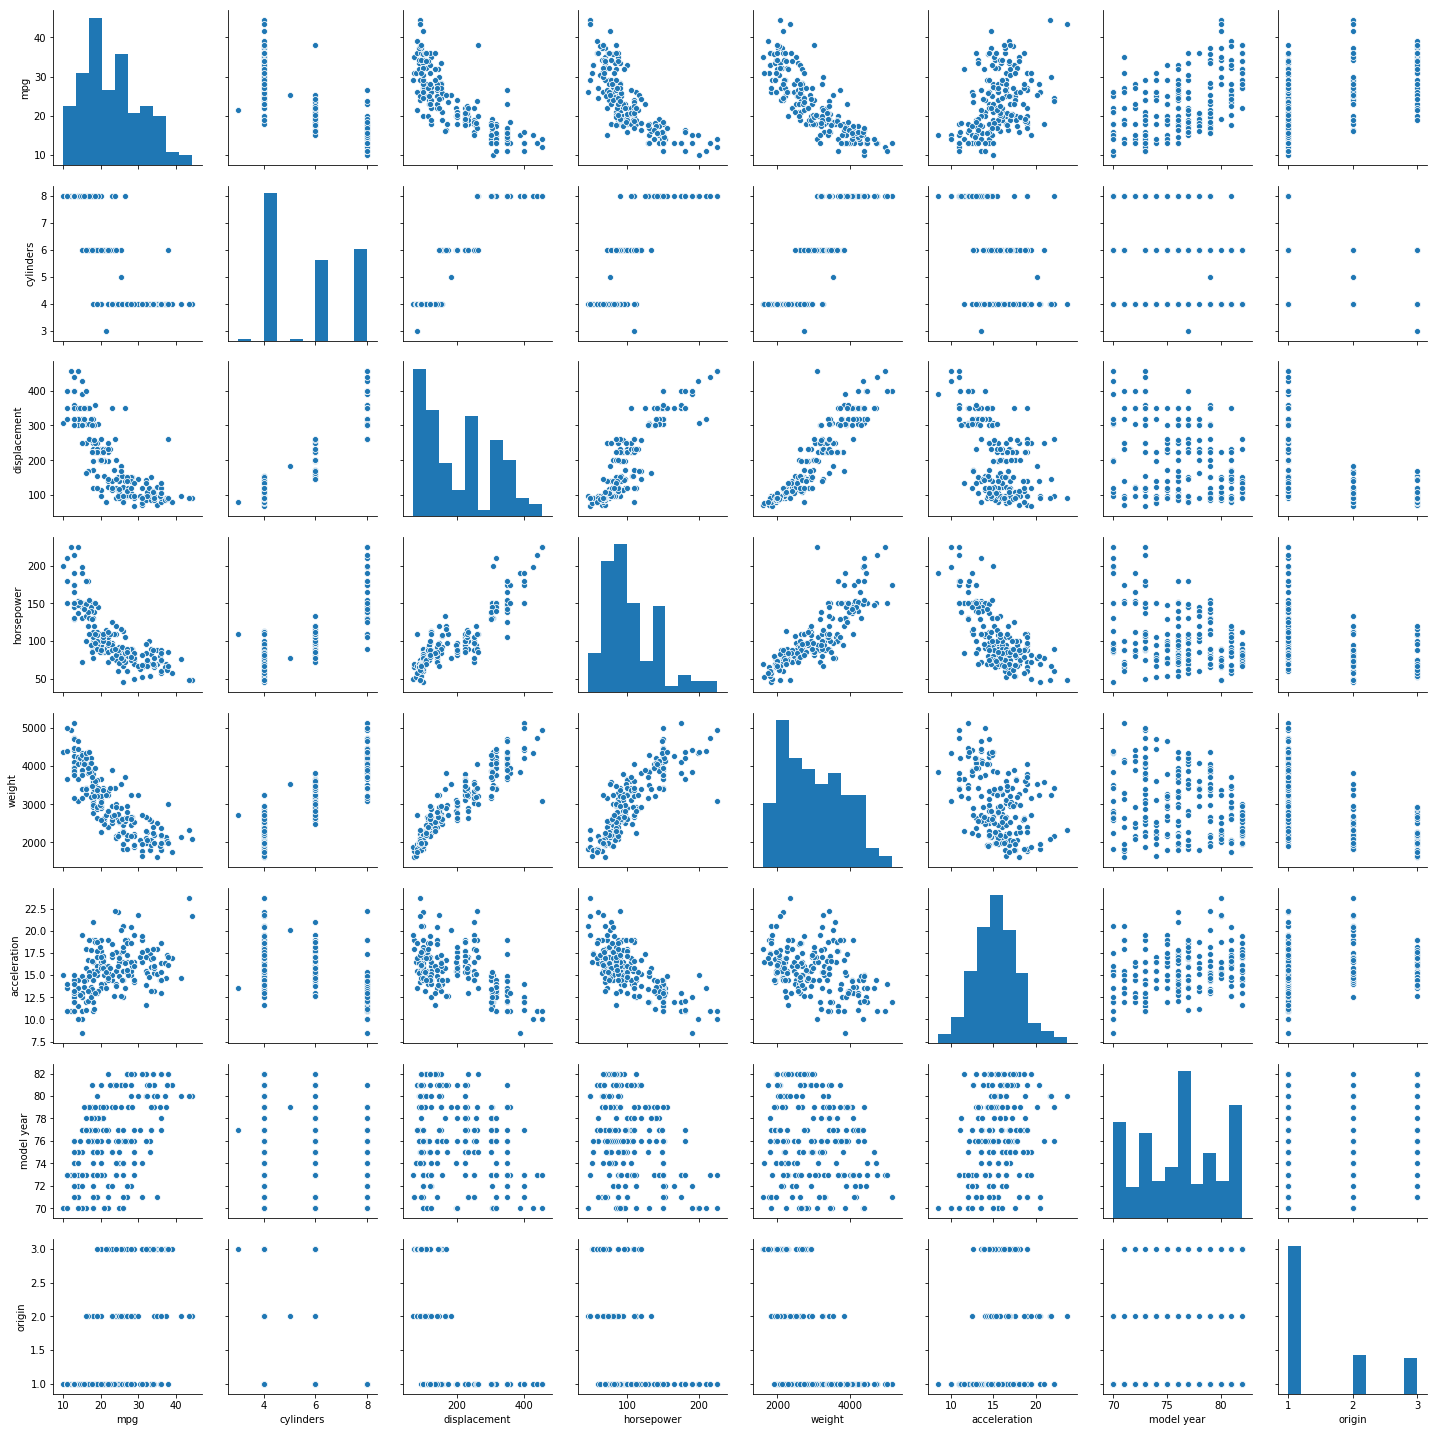

In [58]:
sns.pairplot(train)

There appear to be somet funny things going on in the "cylinders" column. These are typically paired, so odd numbers are unusual. Let's look at that.

In [63]:
train[train.cylinders%2!=0]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
243,21.5,3,80.0,110.0,2720.0,13.5,77,3,mazda rx-4
297,25.4,5,183.0,77.0,3530.0,20.1,79,2,mercedes benz 300d


A wikipedia search for the [Mercedes 300D](https://en.wikipedia.org/wiki/Mercedes-Benz_W123) reveals that it was, in fact, offered in an inline-5 cylinder configuration.

On the other hand, the [Mazda RX-4](https://en.wikipedia.org/wiki/Mazda_Luce#Mazda_RX-4) was not offered in a 3-cylinder configuration. It's possible that this refers to the rotary Wankel engine. Cars with this engine were sold during this time period, which provides some coroborating evidence.

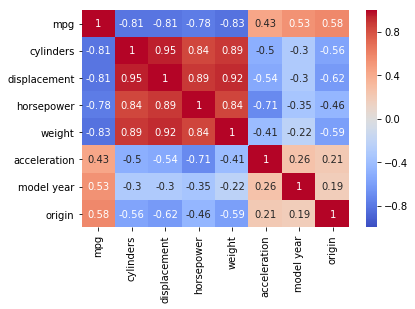

In [62]:
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')

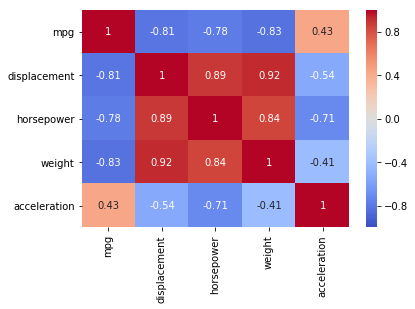

In [65]:
sns.heatmap(train_continuous.corr(), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')

In [66]:
train[train.origin==2]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
19,26.0,4,97.0,46.0,1835.0,20.5,70,2,volkswagen 1131 deluxe sedan
20,25.0,4,110.0,87.0,2672.0,17.5,70,2,peugeot 504
23,26.0,4,121.0,113.0,2234.0,12.5,70,2,bmw 2002
55,27.0,4,97.0,60.0,1834.0,19.0,71,2,volkswagen model 111
76,18.0,4,121.0,112.0,2933.0,14.5,72,2,volvo 145e (sw)
114,26.0,4,98.0,90.0,2265.0,15.5,73,2,fiat 124 sport coupe
117,29.0,4,68.0,49.0,1867.0,19.5,73,2,fiat 128
118,24.0,4,116.0,75.0,2158.0,15.5,73,2,opel manta
119,20.0,4,114.0,91.0,2582.0,14.0,73,2,audi 100ls
120,19.0,4,121.0,112.0,2868.0,15.5,73,2,volvo 144ea


In [70]:
train[train.cylinders==6].loc[train[train.cylinders==6]['mpg'].idxmax()]

mpg                                            38
cylinders                                       6
displacement                                  262
horsepower                                     85
weight                                       3015
acceleration                                   17
model year                                     82
origin                                          1
car name        oldsmobile cutlass ciera (diesel)
Name: 387, dtype: object